In [3]:
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

import utils

user_id = 2
db_name = 'oolong'
db_conn = create_engine('postgresql://localhost/'+db_name)

sns.set() # default styling
utils.load_css()

In [25]:
# load data from database
dfs = {}

# question response data
df = pd.read_sql_table('plot_response', db_conn)
df = df[df.user_id==user_id]

tmp = df.pivot(index='date', columns='questionnaire', values='avg')
tmp.columns = [l + ' (avg)' for l in tmp.columns]
tmp.index = pd.to_datetime(tmp.index)
dfs['avg'] = tmp
tmp = df.pivot(index='date', columns='questionnaire', values='median')
tmp.columns = [l + ' (median)' for l in tmp.columns]
tmp.index = pd.to_datetime(tmp.index)
dfs['median'] = tmp

# drink metric
df = pd.read_sql_table('plot_drink', db_conn)
df = df[df.user_id==user_id]
dfs['drink'] = df.pivot(index='date',columns='type',values='sum')

# sleep metric
df = pd.read_sql_table('metric_sleep', db_conn)
df = df[df.user_id==user_id]
df['date'] = df.time_stamp.dt.date
df['sleep_duration_hr'] = df.end - df.time_stamp
df['sleep_duration_min'] = df.sleep_duration_hr / pd.Timedelta('1 minute')
dfs['sleep'] = df.set_index('date')[['sleep_duration_min']]

# daily metric
df = pd.read_sql_table('metric_daily', db_conn)
df['date'] = df.time_stamp.dt.date
df = df[df.user_id==user_id]
dfs['daily'] = df.pivot(index='date',columns='type',values='value')

# merge all data into a single df where each row is a day
# and each column a feature
dat = dfs['median']
for k,v in dfs.items():
    if k != 'median':
        dat = dat.join(v)
        
dat.fillna(0, inplace=True)
dat.head()

,Anxiety (median),Depression (median),Happiness (median),Anxiety (avg),Depression (avg),Happiness (avg),alcohol,coffee,soda,tea,water,sleep_duration_min,screen_time,steps
date,,,,,,,,,,,,,,
2018-03-04,1.0,4.0,5.0,2.6,3.454545,4.888889,24.0,4.0,0.0,0.0,32.0,529.200000,0.0,0.0
2018-03-05,3.5,5.0,3.0,3.2,4.909091,3.222222,0.0,12.0,0.0,12.0,63.0,480.300000,0.0,5177.0
2018-03-06,1.0,3.0,4.0,1.5,3.272727,3.888889,12.0,12.0,0.0,24.0,48.0,501.316667,84.0,3027.0
2018-03-07,4.0,5.0,2.0,4.0,5.090909,2.222222,12.0,12.0,0.0,24.0,24.0,480.333333,94.0,4003.0
2018-03-08,1.0,2.0,5.0,1.6,2.181818,4.333333,12.0,12.0,0.0,24.0,24.0,529.033333,138.0,2469.0


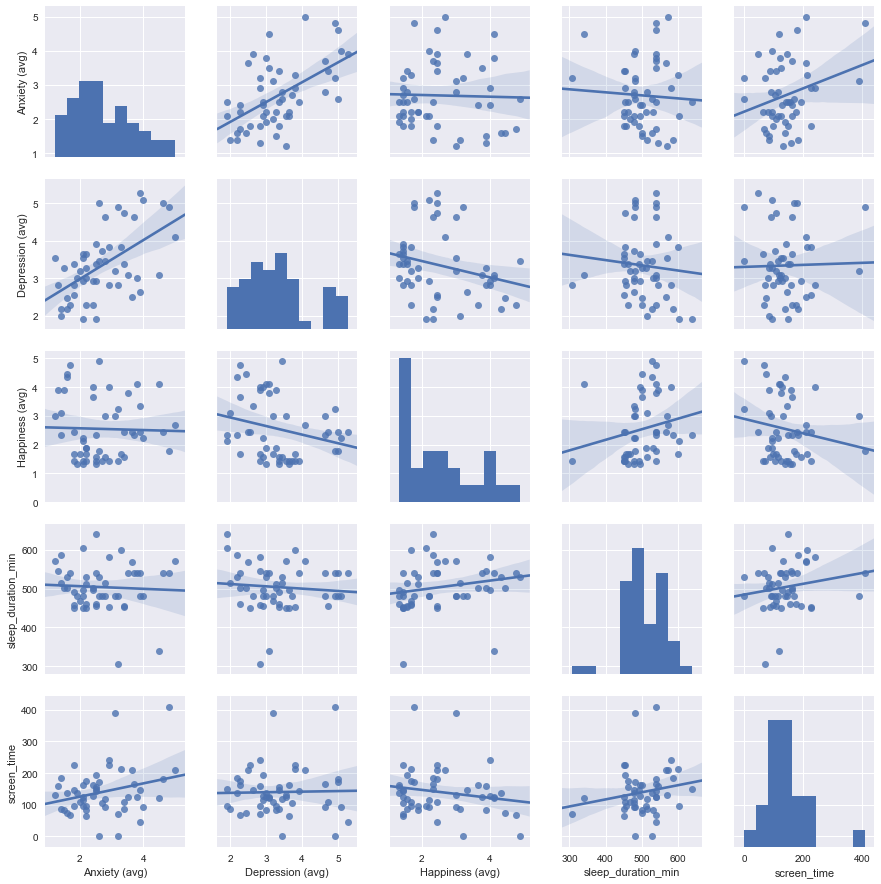

In [37]:
mood = ["Anxiety (avg)", "Depression (avg)", "Happiness (avg)"]
features = ['sleep_duration_min','screen_time']
plot_cols = mood + features
g = sns.pairplot(dat, vars=plot_cols, kind='reg')